## Download Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
! unzip /content/drive/MyDrive/plate-dataset-char.zip

Streaming output truncated to the last 5000 lines.
  inflating: plate-dataset-char/labels/1095.json  
  inflating: plate-dataset-char/labels/1097.json  
  inflating: plate-dataset-char/labels/1098.json  
  inflating: plate-dataset-char/labels/110.json  
  inflating: plate-dataset-char/labels/1100.json  
  inflating: plate-dataset-char/labels/1101.json  
  inflating: plate-dataset-char/labels/1102.json  
  inflating: plate-dataset-char/labels/1103.json  
  inflating: plate-dataset-char/labels/1104.json  
  inflating: plate-dataset-char/labels/1105.json  
  inflating: plate-dataset-char/labels/1106.json  
  inflating: plate-dataset-char/labels/1107.json  
  inflating: plate-dataset-char/labels/111.json  
  inflating: plate-dataset-char/labels/1110.json  
  inflating: plate-dataset-char/labels/1112.json  
  inflating: plate-dataset-char/labels/1113.json  
  inflating: plate-dataset-char/labels/1114.json  
  inflating: plate-dataset-char/labels/1115.json  
  inflating: plate-dataset-char/l

## Download yolov5 models


In [9]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.1-266-g34df503 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.0/78.2 GB disk)


## Prepare Dataset

In [10]:
import os
import numpy as np
from pathlib import Path
import cv2
import json
import glob
from shutil import copyfile

In [11]:
FILE_ROOT = "/content/plate-dataset-char/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "labels"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [12]:
!mkdir -p Dataset/train/labels

In [13]:
# copy images
!cp -rf /content/plate-dataset-char/images Dataset/train

In [14]:
!mkdir -p Dataset/val/images
!cp -rf /content/plate-dataset-char/images/1*.jpg Dataset/val/images

In [15]:
def save_yolo_format(image_file, json_file, txt_file):
    with open(json_file) as f:
        chars = json.loads(f.read())

    bgr = cv2.imread(image_file)

    result = ""
    for char in chars:
        x_center = (char["x"] + char["width"] // 2) / bgr.shape[1]
        y_center = (char["y"] + char["height"] // 2) / bgr.shape[0]

        width = char["width"] / bgr.shape[1]
        height = char["height"] / bgr.shape[0]

        label = char["char_id"]

        result += str(label) + " " + str(x_center) + " " + str(y_center) + " " + str(width) + " " + str(height) + "\n"

    with open(txt_file, "w+") as f:
        f.write(result)

for image in glob.glob('Dataset/train/images/*.jpg'):
    num = image.split('/')[-1].split('.')[0]
    save_yolo_format(image,
                    "/content/plate-dataset-char/labels/"+ num +".json",
                    "Dataset/train/labels/"+ num +".txt")


In [16]:
id = []
for json_file in glob.glob('/content/plate-dataset-char/labels/*.json'):
    with open(json_file) as f:
        chars = json.loads(f.read())
    for char in chars:
        label = char["char_id"]
        id.append(label)
set(id)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36}

In [19]:
! mkdir -p Dataset/val/labels
! cp Dataset/train/labels/1*.txt Dataset/val/labels

## Training YOLO

In [18]:
!echo "train: Dataset/train/images" > data/plate-char-detection.yaml
!echo "val:   Dataset/val/images" >> data/plate-char-detection.yaml

!echo "nc: 37" >> data/plate-char-detection.yaml
!echo "names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '31', '32', '33', '34', '35', '36', '37']" >> data/plate-char-detection.yaml

!cat data/plate-char-detection.yaml

train: Dataset/train/images
val:   Dataset/val/images
nc: 37
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '31', '32', '33', '34', '35', '36', '37']


In [20]:
!python train.py --img 416 --batch 16 --epochs 50 --data data/plate-char-detection.yaml --cfg models/yolov5m.yaml 

train: weights=yolov5s.pt, cfg=models/yolov5m.yaml, data=data/plate-char-detection.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-266-g34df503 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h

## YOLOv5 Detect

In [21]:
!python detect.py --source /content/45767y8uhn-1024x580-1.jpg --weights runs/train/exp/weights/best.pt --conf 0.25 --name yolo_plate_det

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/45767y8uhn-1024x580-1.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_plate_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-266-g34df503 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20998410 parameters, 0 gradients
image 1/1 /content/45767y8uhn-1024x580-1.jpg: 384x640 1 0, 2 1s, 2 2s, 1 4, 1 9, 1 22, Done. (0.023s)
Speed: 0.4ms pre-process, 22.7ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolo_plate_det


### Display Detected Images

In [22]:
from IPython.display import Image

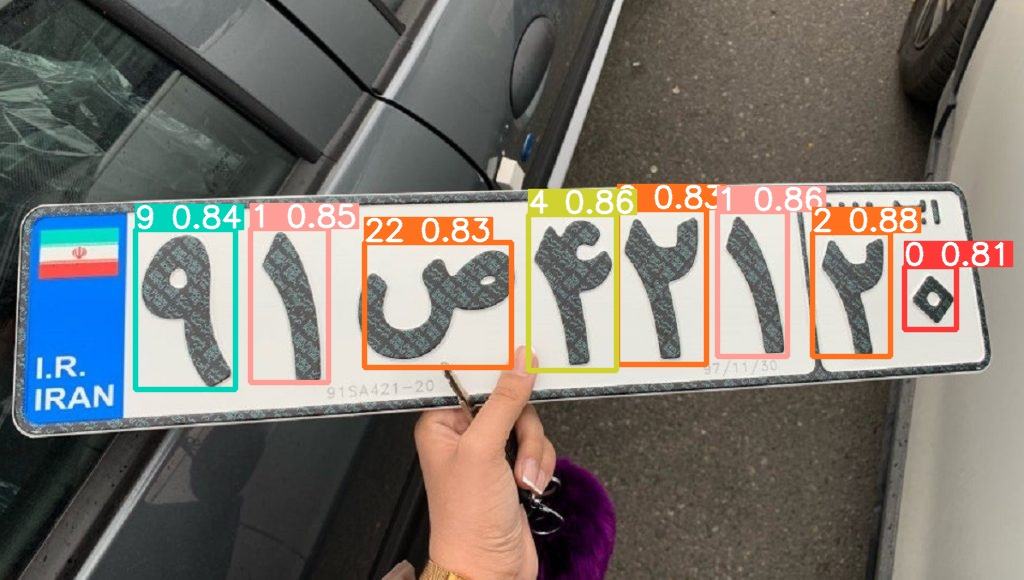

In [23]:
Image('/content/yolov5/runs/detect/yolo_plate_det/45767y8uhn-1024x580-1.jpg')